# LOGOTS
Transformation layer notebook

In [271]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
import time
import ast
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

In [473]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Audio Transformations

## 1. Upload CSVs

In [275]:
stg_audio_data = pd.read_csv("stg_audio_data.csv")

In [277]:
# Convert `audio_samples` column from string to list
stg_audio_data['audio_samples'] = stg_audio_data['audio_samples'].apply(ast.literal_eval)

In [279]:
stg_audio_data.head(10)

,frame_id,timestamp,audio_samples
0,0,2024-11-20 15:25:02.250119,"[-481, 0, 0, -240, -240, -722, -722, -722, -72..."
1,1,2024-11-20 15:25:02.289591,"[-843, -843, 240, 240, 361, 361, 361, 361, -24..."
2,2,2024-11-20 15:25:02.316173,"[-602, -602, -120, -120, -722, -722, -602, -60..."
3,3,2024-11-20 15:25:02.379662,"[722, 722, -361, -361, -361, -361, -481, -481,..."
4,4,2024-11-20 15:25:02.578421,"[1325, 1325, 1325, 1325, 963, 963, 963, 963, 1..."
5,5,2024-11-20 15:25:02.776925,"[-722, -722, -602, -602, -481, -481, 0, 0, 481..."
6,6,2024-11-20 15:25:02.975164,"[1807, 1807, 1807, 1807, 1686, 1686, 1566, 156..."
7,7,2024-11-20 15:25:03.173119,"[-120, -120, 0, 0, 1084, 1084, 1807, 1807, 240..."
8,8,2024-11-20 15:25:03.495915,"[-13612, -13612, -6866, -6866, 602, 602, -6746..."
9,9,2024-11-20 15:25:03.694949,"[-8914, -8914, 1084, 1084, -3493, -3493, -2047..."


## 2. Define Transformation Functions

In [282]:
def compute_fft(samples, sampling_rate=8000):
    """
    Computes the FFT for the given audio samples.

    Parameters:
        samples (list or np.array): Audio samples.
        sampling_rate (int): Sampling rate of the audio.

    Returns:
        dict: A dictionary with 'freqs' and 'magnitudes'.
    """
    samples = np.array(samples)
    n = len(samples)
    freqs = np.fft.rfftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(np.fft.rfft(samples))
    return {"freqs": freqs, "magnitudes": fft_values}

def classify_voice_or_noise(freqs, magnitudes, voice_freq_range=(500, 3500), energy_threshold=15000000):
    """
    Classifies whether the given frequencies and magnitudes represent a voice or noise.

    Parameters:
        freqs (list or np.array): Frequencies from the FFT.
        magnitudes (list or np.array): Corresponding magnitudes for the frequencies.
        voice_freq_range (tuple): The frequency range considered as 'voice'. Default is (85, 255) Hz.
        energy_threshold (float): The minimum energy (sum of magnitudes in the range) to classify as voice.

    Returns:
        str: 'Voice' if the input is classified as voice, 'Noise' otherwise.
    """
    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Find indices within the voice frequency range
    voice_indices = (freqs >= voice_freq_range[0]) & (freqs <= voice_freq_range[1])

    # Calculate total energy in the voice frequency range
    voice_energy = np.sum(magnitudes[voice_indices])

    # Classify based on energy threshold
    if voice_energy > energy_threshold:
        return "Voice"
    else:
        return "Noise"
        

def detect_cat_voice(classification, freqs, magnitudes, freq_range=(400, 700), harmonic_range=(200, 1000), harmonic_threshold=15):
    """
    Determines if the detected voice is a cat's voice based on spectral peaks and harmonic energy.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a cat's voice.
        harmonic_range (tuple): Frequency range for detecting harmonics.
        harmonic_threshold (float): Ratio of harmonic energy to primary peak magnitude to classify as human.

    Returns:
        int: 1 if the detected voice is a cat's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary range (cat voice range)
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_freqs = freqs[primary_mask]
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_freqs) == 0 or len(primary_magnitudes) == 0:
        return 0  # No energy in the cat's voice range

    # Find the primary peak (highest magnitude in the primary range)
    primary_peak_magnitude = primary_magnitudes.max()

    # Check for harmonics in the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Classify as a cat's voice if harmonic energy is low relative to the primary peak
    if harmonic_energy / primary_peak_magnitude < harmonic_threshold:
        return 1  # Cat's voice detected

    return 0  # Not a cat's voice

def detect_human_voice(classification, freqs, magnitudes, freq_range=(150, 600), harmonic_range=(2000, 4000), harmonic_threshold=15):
    """
    Determines if the detected voice is a human's voice based on normalized average of squared magnitudes
    and harmonic energy analysis.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a human's voice.
        harmonic_range (tuple): Frequency range to detect harmonic energy for human voices.
        harmonic_threshold (float): Threshold for detecting significant harmonic energy.

    Returns:
        int: 1 if the detected voice is a human's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary human voice range
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_magnitudes) == 0:
        return 0

    # Calculate normalized average squared magnitude within the primary range
    primary_energy = np.mean(primary_magnitudes**2) / np.max(magnitudes**2)

    # Select frequencies and magnitudes within the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    if len(harmonic_magnitudes) == 0:
        return 0

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Detect human voice if primary energy and harmonic energy exceed thresholds
    if primary_energy > 0.1 and harmonic_energy > harmonic_threshold:
        return 1

    return 0

def calculate_meow_loudness(is_cat_voice, magnitudes):
    """
    Buckets the loudness of a meow into 'low', 'medium', or 'high' if is_cat_voice is True.

    Parameters:
        is_cat_voice (int): 1 if it's a cat's voice, 0 otherwise.
        magnitudes (list): Magnitudes corresponding to the FFT result.

    Returns:
        str: 'low', 'medium', or 'high' if is_cat_voice is True; 'none' otherwise.
    """
    if is_cat_voice != 1:
        return "none"  # Not a cat's voice
    
    # Calculate the average loudness from magnitudes
    avg_loudness = np.mean(magnitudes)

    # Define thresholds for loudness buckets
    if avg_loudness < 40000:  # Threshold for low loudness
        return "low"
    elif 40000 <= avg_loudness <= 60000:  # Threshold for medium loudness
        return "medium"
    else:  # Threshold for high loudness
        return "high"

def calculate_dominant_frequency(freqs, magnitudes):
    """
    Calculates the dominant frequency from the FFT results.

    Parameters:
        freqs (list or array): List or array of frequencies from the FFT result.
        magnitudes (list or array): Corresponding magnitudes for the frequencies.

    Returns:
        float: The frequency with the highest magnitude.
    """
    # Check if freqs or magnitudes are empty
    if freqs.size == 0 or magnitudes.size == 0:
        return 0  # Return 0 if no frequencies or magnitudes are present

    # Find the index of the maximum magnitude
    max_index = np.argmax(magnitudes)

    # Return the frequency corresponding to the max magnitude
    return freqs[max_index]

In [284]:
# Timing function
def measure_time(func, *args, **kwargs):
    """
    Measures the execution time of a function.

    Parameters:
        func (callable): Function to be executed.
        *args: Positional arguments for the function.
        **kwargs: Keyword arguments for the function.

    Returns:
        tuple: (result, execution_time_in_seconds)
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

## 3. Execute functions

In [287]:
new_dataframe = stg_audio_data[['frame_id', 'timestamp']]

In [289]:
# 1. Compute FFT and time it
new_dataframe["fft_result"], fft_time = measure_time(
    lambda: stg_audio_data["audio_samples"].apply(compute_fft)
)
print(f"FFT computation time: {fft_time:.6f} seconds")

# 2. Classify voice or noise and time it
new_dataframe["classification"], classification_time = measure_time(
    lambda: new_dataframe["fft_result"].apply(
        lambda x: classify_voice_or_noise(x["freqs"], x["magnitudes"])
    )
)
print(f"Voice/Noise classification time: {classification_time:.6f} seconds")

# 3. Detect cat voice and time it
new_dataframe["is_cat_voice"], cat_voice_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: detect_cat_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Cat voice detection time: {cat_voice_time:.6f} seconds")

# 4. Detect human voice and time it
new_dataframe["is_human_voice"], human_voice_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: detect_human_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Human voice detection time: {human_voice_time:.6f} seconds")

# 5. Calculate meow loudness and time it
new_dataframe["meow_loudness"], meow_loudness_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: calculate_meow_loudness(
            row["is_cat_voice"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Meow loudness calculation time: {meow_loudness_time:.6f} seconds")

# 6. Calculate dominant frequency and time it
new_dataframe["dominant_frequency"], dominant_frequency_time = measure_time(
    lambda: new_dataframe["fft_result"].apply(
        lambda x: calculate_dominant_frequency(x["freqs"], x["magnitudes"])
    )
)
print(f"Dominant frequency calculation time: {dominant_frequency_time:.6f} seconds")

FFT computation time: 0.012614 seconds
Voice/Noise classification time: 0.001021 seconds
Cat voice detection time: 0.001379 seconds
Human voice detection time: 0.001402 seconds
Meow loudness calculation time: 0.000454 seconds
Dominant frequency calculation time: 0.000329 seconds


In [291]:
new_dataframe.head(50)

,frame_id,timestamp,fft_result,classification,is_cat_voice,is_human_voice,meow_loudness,dominant_frequency
0,0,2024-11-20 15:25:02.250119,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,33.333333
1,1,2024-11-20 15:25:02.289591,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,152.380952
2,2,2024-11-20 15:25:02.316173,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,19.047619
3,3,2024-11-20 15:25:02.379662,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
4,4,2024-11-20 15:25:02.578421,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
5,5,2024-11-20 15:25:02.776925,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
6,6,2024-11-20 15:25:02.975164,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
7,7,2024-11-20 15:25:03.173119,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Voice,1,0,high,666.666667
8,8,2024-11-20 15:25:03.495915,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Voice,1,0,high,595.238095
9,9,2024-11-20 15:25:03.694949,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Voice,1,0,high,1195.238095


## 4. Visualize Data

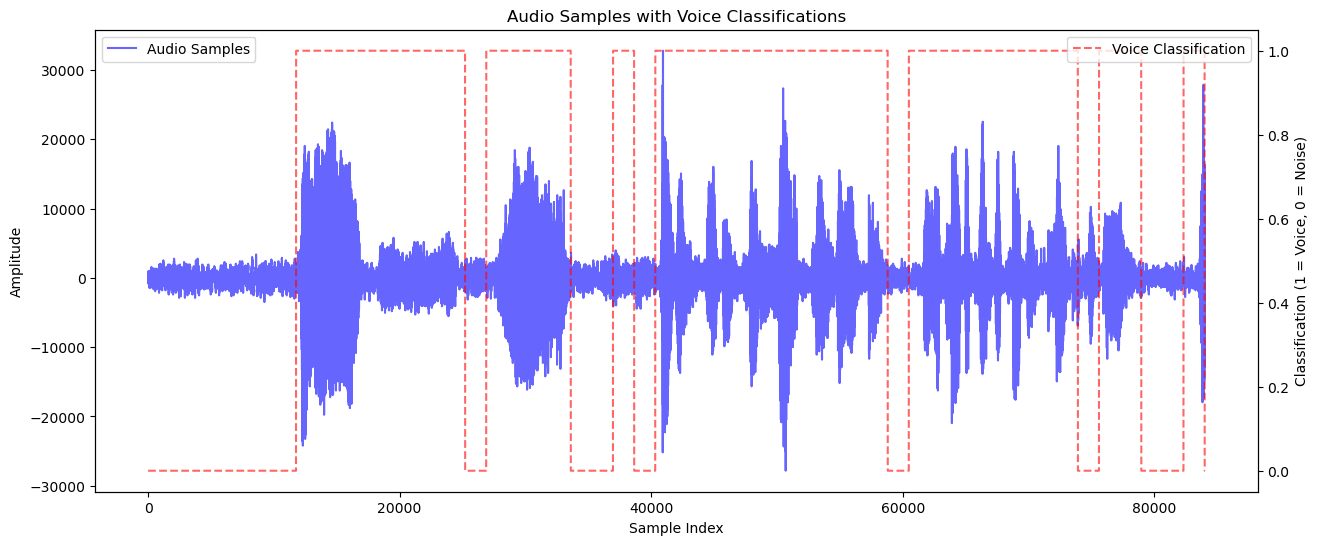

In [294]:
def plot_audio_with_classifications(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `classification`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the classifications to align with the concatenated audio
    classifications = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get classification for the frame from new_dataframe
        classification = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "classification"
        ].values
        if len(classification) > 0:
            classifications.append(1 if classification[0] == "Voice" else 0)
        else:
            classifications.append(0)  # Default to 0 if no classification

    # Expand classifications to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_classifications = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_classifications.extend([classifications[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_classifications, label="Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Voice, 0 = Noise)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_classifications(stg_audio_data, new_dataframe)

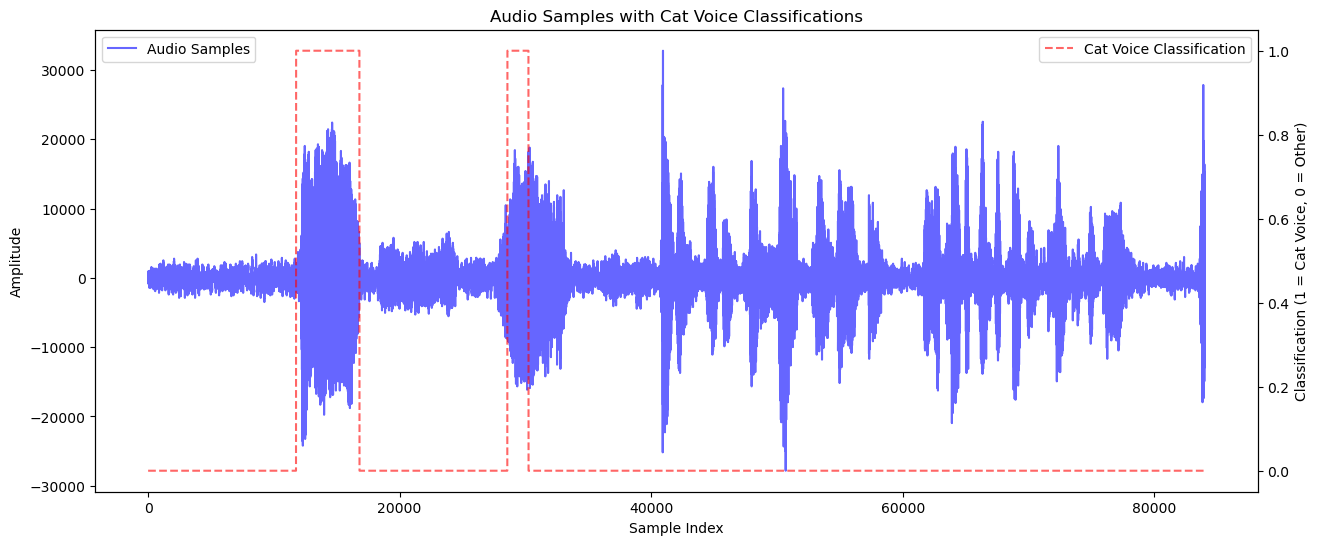

In [296]:
def plot_audio_with_cat_voice(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with cat voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `is_cat_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_cat_voice values to align with the concatenated audio
    cat_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_cat_voice for the frame from new_dataframe
        is_cat_voice = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "is_cat_voice"
        ].values
        if len(is_cat_voice) > 0:
            cat_voice_flags.append(is_cat_voice[0])
        else:
            cat_voice_flags.append(0)  # Default to 0 if no classification

    # Expand cat voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_cat_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_cat_voice_flags.extend([cat_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot cat voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_cat_voice_flags, label="Cat Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Cat Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Cat Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_cat_voice(stg_audio_data, new_dataframe)

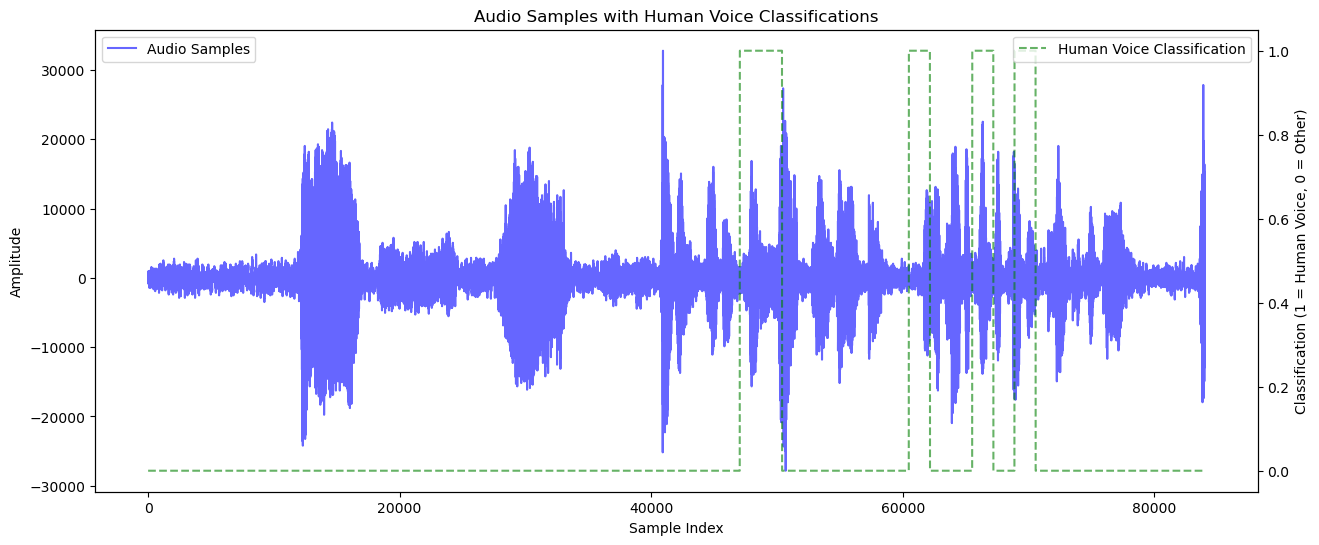

In [298]:
def plot_audio_with_human_voice(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with human voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `is_human_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_human_voice values to align with the concatenated audio
    human_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_human_voice for the frame from new_dataframe
        is_human_voice = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "is_human_voice"
        ].values
        if len(is_human_voice) > 0:
            human_voice_flags.append(is_human_voice[0])
        else:
            human_voice_flags.append(0)  # Default to 0 if no classification

    # Expand human voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_human_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_human_voice_flags.extend([human_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot human voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_human_voice_flags, label="Human Voice Classification", color="green", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Human Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Human Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_human_voice(stg_audio_data, new_dataframe)

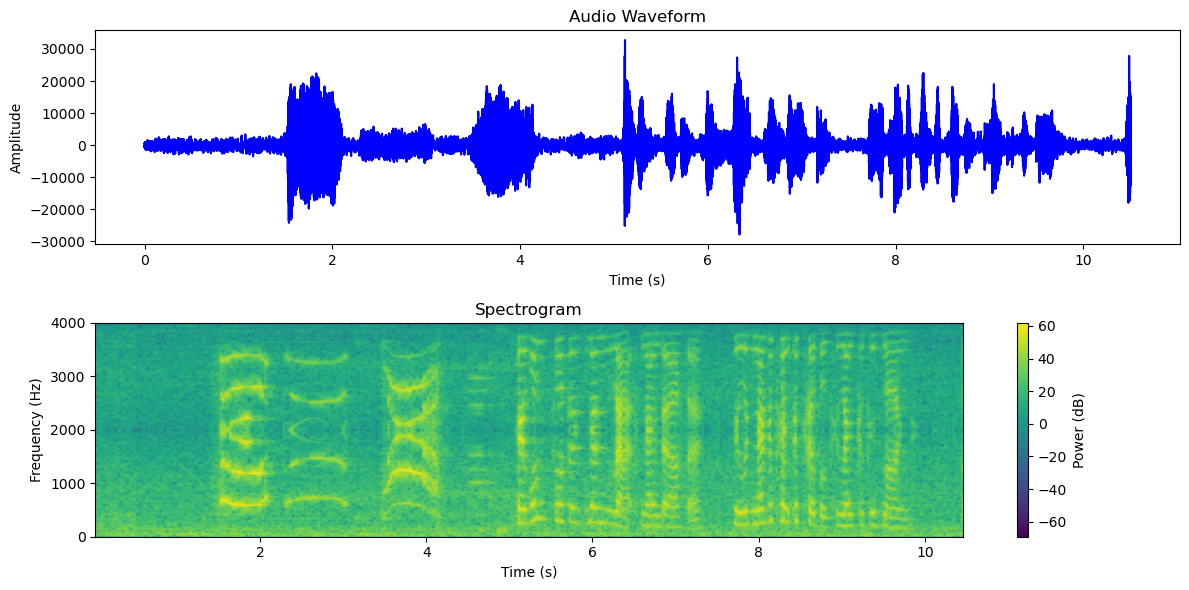

In [300]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and spectrogram
def plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=8000):
    """
    Plots the concatenated audio waveform and its spectrogram.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 8000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=8000)

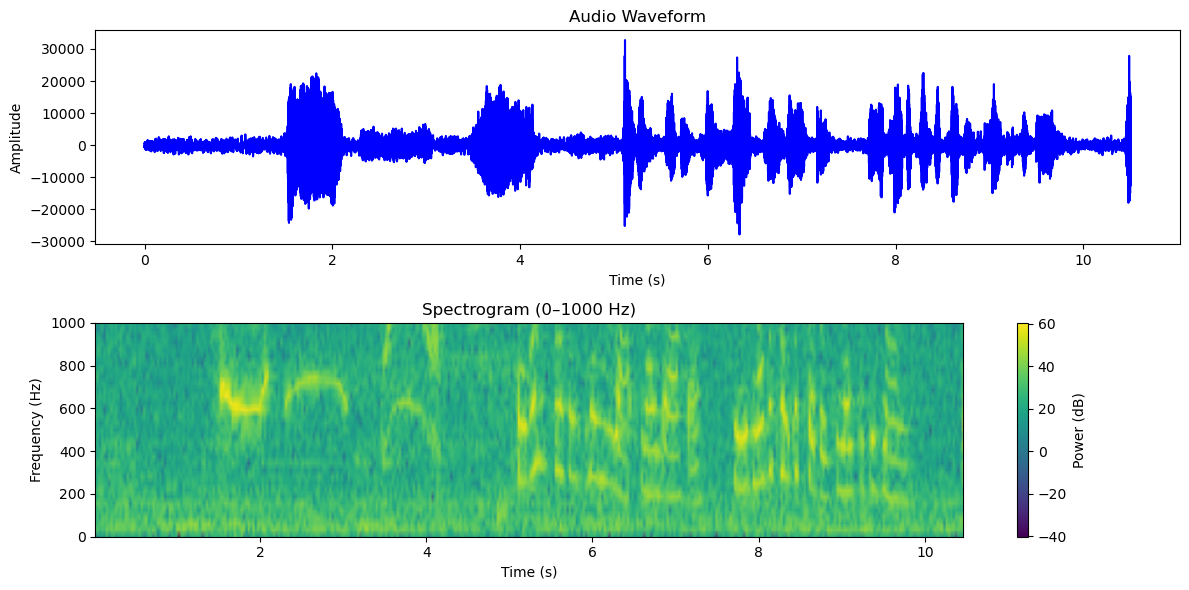

In [302]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and zoomed-in spectrogram (0–1000 Hz)
def plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=8000):
    """
    Plots the concatenated audio waveform and its spectrogram, zoomed in to 0–1000 Hz.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 8000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Filter for frequencies up to 1000 Hz
    freq_limit = 1000
    freq_mask = f <= freq_limit
    f_zoomed = f[freq_mask]
    Sxx_zoomed = Sxx[freq_mask, :]

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram zoomed in to 0–1000 Hz
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f_zoomed, 10 * np.log10(Sxx_zoomed + 1e-10), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram (0–1000 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=8000)

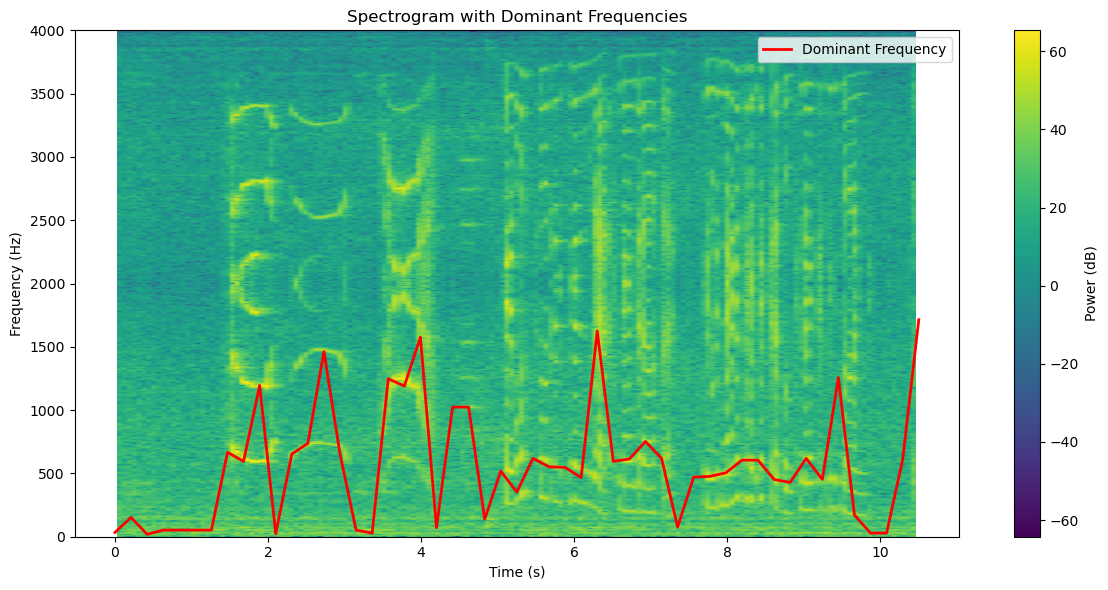

In [304]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming new_dataframe and stg_audio_data are already defined
# Extract necessary data
audio_samples = np.concatenate(stg_audio_data["audio_samples"].values)
timestamps = np.cumsum([0] + [len(samples) for samples in stg_audio_data["audio_samples"].values[:-1]]) / 8000  # Convert to seconds
dominant_frequencies = new_dataframe["dominant_frequency"]

# Create the spectrogram
sampling_rate = 8000  # Assuming audio is sampled at 8 kHz
plt.figure(figsize=(12, 6))
plt.specgram(audio_samples, Fs=sampling_rate, NFFT=1024, noverlap=512, cmap="viridis")
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram with Dominant Frequencies")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Align dominant_frequencies with timestamps
dominant_timestamps = timestamps  # One timestamp per frame
plt.plot(dominant_timestamps, dominant_frequencies, color="red", label="Dominant Frequency", linewidth=2)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# IMU Transformations

In [397]:
stg_imu_data = pd.read_csv("stg_imu_data.csv")

In [399]:
# Convert samples column from string to list
stg_imu_data['yaw'] = stg_imu_data['yaw'].apply(ast.literal_eval)
stg_imu_data['pitch'] = stg_imu_data['pitch'].apply(ast.literal_eval)
stg_imu_data['roll'] = stg_imu_data['roll'].apply(ast.literal_eval)

In [401]:
# Extract the first element if the value is a list
imu_df['yaw'] = imu_df['yaw'].apply(lambda x: x[0] if isinstance(x, list) else x)
imu_df['pitch'] = imu_df['pitch'].apply(lambda x: x[0] if isinstance(x, list) else x)
imu_df['roll'] = imu_df['roll'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [403]:
stg_imu_data

,frame_id,timestamp,yaw,pitch,roll
0,0,2025-02-12 20:32:50.669968,"[331.83, 331.83, 331.82, 331.82, 331.82, 331.8...","[0.35, 0.42, 0.51, 0.5, 0.48, 0.49, 0.37, 0.41...","[0.56, 0.49, 0.44, 0.47, 0.74, 0.47, 0.47, 0.4..."
1,1,2025-02-12 20:32:50.870267,"[331.6, 331.6, 331.59, 331.59, 331.58, 331.58,...","[0.48, 0.39, 0.53, 0.26, 0.4, 0.49, 0.48, 0.48...","[0.44, 0.74, 0.29, 0.47, 0.39, 0.44, 0.47, 0.4..."
2,2,2025-02-12 20:32:51.074309,"[331.64, 331.63, 331.63, 331.63, 331.62, 331.5...","[0.46, 0.55, 0.48, 0.68, 0.35, 0.45, 0.27, 0.5...","[0.64, 0.42, 0.54, 0.81, 0.64, 0.44, 0.76, 0.5..."
3,3,2025-02-12 20:32:51.256989,"[331.58, 331.58, 331.57, 331.58, 331.58, 331.5...","[0.55, 0.55, 0.68, 0.46, 0.51, 0.43, 0.44, 0.6...","[0.39, 0.42, 0.34, 0.64, 0.64, 0.59, 0.64, 0.4..."
4,4,2025-02-12 20:32:51.453278,"[331.38, 331.38, 331.38, 331.38, 331.37, 331.3...","[0.31, 0.39, 0.47, 0.54, 0.67, 0.46, 0.51, 0.3...","[0.37, 0.54, 0.54, 0.59, 0.44, 0.56, 0.37, 0.5..."
...,...,...,...,...,...
200,200,2025-02-12 20:33:29.875468,"[314.4, 313.57, 312.54, 311.63, 311.79, 310.88...","[-2.23, -0.96, 0.85, 1.15, 1.35, -2.41, -0.3, ...","[1.92, -2.92, -7.47, -4.73, 2.99, 4.35, 7.32, ..."
201,201,2025-02-12 20:33:30.067457,"[303.94, 303.02, 302.13, 301.21, 300.15, 299.1...","[-1.54, -2.37, 0.45, -0.33, 0.53, -1.56, -2.71...","[-5.74, -0.65, -0.09, 4.16, -3.74, 3.75, 4.93,..."
202,202,2025-02-12 20:33:30.261961,"[290.57, 289.47, 288.29, 288.1, 287.11, 285.94...","[-3.0, -0.69, -3.1, -0.29, 0.98, -4.55, -2.35,...","[-3.91, -1.99, 1.93, 5.41, 8.24, 1.71, -5.62, ..."
203,203,2025-02-12 20:33:30.457813,"[274.63, 273.43, 271.58, 270.06, 268.53, 266.8...","[-7.47, -5.87, 0.92, -1.47, -3.23, -5.78, -2.2...","[-0.09, -30.18, 8.1, 7.7, -0.51, 3.36, 6.55, 7..."


In [517]:
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

def extract_scalar(x):
    return x[0] if isinstance(x, list) else x

# --- Feature Functions ---

def unwrap_yaw(yaw_list):
    """
    Unwrap the yaw values (in degrees) using numpy.unwrap.
    Returns the unwrapped array.
    """
    arr = np.array(yaw_list, dtype=float)
    return np.degrees(np.unwrap(np.radians(arr)))

def avg_intra_yaw_diff(yaw_list):
    """
    For the given row's yaw (a list), unwrap it, compute the differences
    between consecutive values, and return the average difference.
    """
    unwrapped = unwrap_yaw(yaw_list)
    if len(unwrapped) > 1:
        diffs = np.diff(unwrapped)
        return np.mean(diffs)
    else:
        return 0.0

def compute_rotation_speed(current_yaw_list, prev_avg_yaw):
    """
    Compute rotation speed using only yaw.
      1. Compute the average intra-row yaw difference.
      2. Compute delta_yaw = current_avg - prev_avg (if available).
      3. Return absolute delta_yaw as the rotation speed, along with current_avg and raw delta.
    """
    current_avg = avg_intra_yaw_diff(current_yaw_list)
    if prev_avg_yaw is None:
        delta_yaw = 0.0
    else:
        delta_yaw = current_avg - prev_avg_yaw
    rotation_speed = abs(delta_yaw)
    return rotation_speed, current_avg, delta_yaw

def compute_movement_intensity(delta_yaw, delta_pitch, delta_roll):
    """
    Compute movement intensity as the Euclidean norm of (delta_yaw, delta_pitch, delta_roll).
    """
    return np.sqrt(delta_yaw**2 + delta_pitch**2 + delta_roll**2)

def compute_balance_state(pitch, roll, movement_intensity):
    """
    The robot is balanced if pitch and roll are within ±15° and movement_intensity is low (< 0.3).
    """
    return (abs(pitch) < 15) and (abs(roll) < 15) and (movement_intensity < 0.3)

def compute_cat_interaction(delta_pitch):
    """
    Flag a cat interaction if movement_intensity exceeds a certain value.
    """
    return abs(delta_pitch) > 15

def compute_is_rest(movement_intensity):
    """
    Mark as rest if movement_intensity is very low (< 1).
    """
    return movement_intensity < 1

In [519]:
# --- Live Processing Functions ---

def process_frame(row, state):
    """
    Process one IMU frame (one row) in live mode.
    Uses only previous frame values (stored in state) to compute differences.
    Each feature is computed by its own function.
    Returns a dict with all computed features.
    """
    # --- Rotation Speed (yaw only) ---
    rotation_speed, current_avg_yaw, delta_yaw = compute_rotation_speed(row['yaw'], state.get('prev_avg_yaw'))
    
    # --- Pitch and Roll differences ---
    # For pitch and roll, we assume they are already extracted as scalars.
    pitch = row['pitch']
    roll  = row['roll']
    if state.get('prev_pitch') is None:
        delta_pitch = 0.0
    else:
        delta_pitch = pitch - state['prev_pitch']
    if state.get('prev_roll') is None:
        delta_roll = 0.0
    else:
        delta_roll = roll - state['prev_roll']
    
    # --- Movement Intensity ---
    movement_intensity = compute_movement_intensity(delta_yaw, delta_pitch, delta_roll)
    
    # --- Balance State ---
    balance_state = compute_balance_state(pitch, roll, movement_intensity)
    
    # --- Cat Interaction ---
    cat_interaction_detected = compute_cat_interaction(delta_pitch)
    
    # --- is_rest Feature ---
    is_rest = compute_is_rest(movement_intensity)
    
    # --- Update state for live processing ---
    state['prev_avg_yaw'] = current_avg_yaw
    state['prev_pitch'] = pitch
    state['prev_roll'] = roll
    
    return {
        'frame_id': row['frame_id'],
        'timestamp': row['timestamp'],
        'rotation_speed': rotation_speed,
        'movement_intensity': movement_intensity,
        'balance_state': balance_state,
        'cat_interaction_detected': cat_interaction_detected,
        'is_rest': is_rest,
        # Optionally, include deltas for debugging/tuning:
        'delta_yaw': delta_yaw,
        'delta_pitch': delta_pitch,
        'delta_roll': delta_roll
    }

def process_imu_live(imu_df):
    """
    Process the entire IMU DataFrame row by row (live data simulation)
    and return a transformed table with computed features.
    """
    state = {'prev_avg_yaw': None, 'prev_pitch': None, 'prev_roll': None}
    results = []
    for _, row in imu_df.iterrows():
        features = process_frame(row, state)
        results.append(features)
    return pd.DataFrame(results)

In [521]:
# --- Main Processing Cell ---

# Prepare and clean IMU data.
# (Assumes your pre-cells have done the following:
# 1. stg_imu_data = pd.read_csv("stg_imu_data.csv")
# 2. Converting 'yaw', 'pitch', 'roll' from string to list.
# 3. For pitch and roll, extracting the first element; leave yaw as the full list.)
imu_df = stg_imu_data[['frame_id', 'timestamp', 'yaw', 'pitch', 'roll']].copy()
imu_df['pitch'] = imu_df['pitch'].apply(lambda x: x[0] if isinstance(x, list) else x)
imu_df['roll']  = imu_df['roll'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Do NOT extract yaw (we need the full list for intra-row processing).

# Process the IMU data live and obtain the mart table.
trans_imu_features = process_imu_live(imu_df)

# Optionally, inspect the transformed table.
print(trans_imu_features.describe())

         frame_id  rotation_speed  movement_intensity   delta_yaw  \
count  205.000000      205.000000          205.000000  205.000000   
mean   102.000000        0.222811           10.469805   -0.007426   
std     59.322565        0.444616           19.810080    0.497509   
min      0.000000        0.000000            0.000000   -1.880769   
25%     51.000000        0.013846            1.514992   -0.052308   
50%    102.000000        0.043846            6.659075   -0.001538   
75%    153.000000        0.144615           13.097671    0.043846   
max    204.000000        2.504615          187.268559    2.504615   

       delta_pitch  delta_roll  
count   205.000000  205.000000  
mean     -0.058878   -0.089024  
std      10.897441   19.585203  
min     -75.800000 -168.390000  
25%      -2.720000   -2.630000  
50%       0.020000    0.000000  
75%       2.500000    4.420000  
max      81.940000  170.720000  


In [523]:
trans_imu_features

,frame_id,timestamp,rotation_speed,movement_intensity,balance_state,cat_interaction_detected,is_rest,delta_yaw,delta_pitch,delta_roll
0,0,2025-02-12 20:32:50.669968,0.000000e+00,0.000000,True,False,True,0.000000e+00,0.00,0.00
1,1,2025-02-12 20:32:50.870267,2.153846e-02,0.178224,True,False,True,2.153846e-02,0.13,-0.12
2,2,2025-02-12 20:32:51.074309,1.461538e-02,0.201528,True,False,True,-1.461538e-02,-0.02,0.20
3,3,2025-02-12 20:32:51.256989,3.076923e-03,0.265724,True,False,True,-3.076923e-03,0.09,-0.25
4,4,2025-02-12 20:32:51.453278,1.076923e-02,0.241073,True,False,True,1.076923e-02,-0.24,-0.02
5,5,2025-02-12 20:32:51.657004,1.615385e-02,0.278318,True,False,True,1.615385e-02,0.14,0.24
6,6,2025-02-12 20:32:51.858843,3.846154e-02,0.168462,True,False,True,-3.846154e-02,-0.10,0.13
7,7,2025-02-12 20:32:52.040991,3.000000e-02,0.510196,False,False,True,3.000000e-02,0.37,-0.35
8,8,2025-02-12 20:32:52.237008,3.076923e-03,0.255557,True,False,True,-3.076923e-03,-0.22,0.13
9,9,2025-02-12 20:32:52.433392,3.307692e-02,0.130744,True,False,True,-3.307692e-02,-0.04,0.12


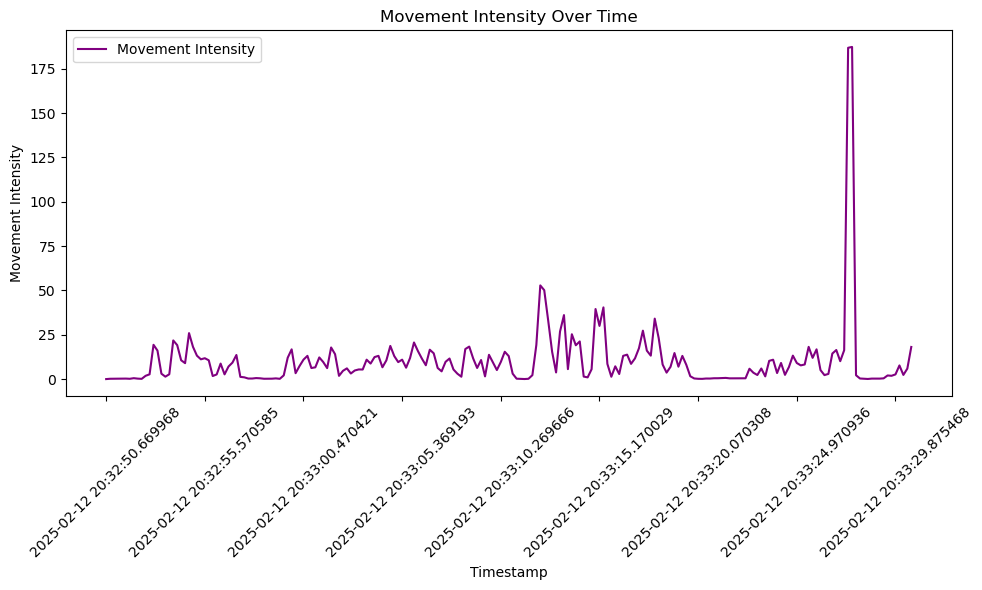

In [525]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
plt.plot(trans_imu_features['timestamp'], trans_imu_features['movement_intensity'],
         label='Movement Intensity', color='purple')
plt.title('Movement Intensity Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Movement Intensity')
plt.legend()

# Rotate timestamps to avoid overlap
plt.xticks(rotation=45)

# Optionally limit the number of x-axis ticks to reduce clutter
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))

plt.tight_layout()
plt.show()

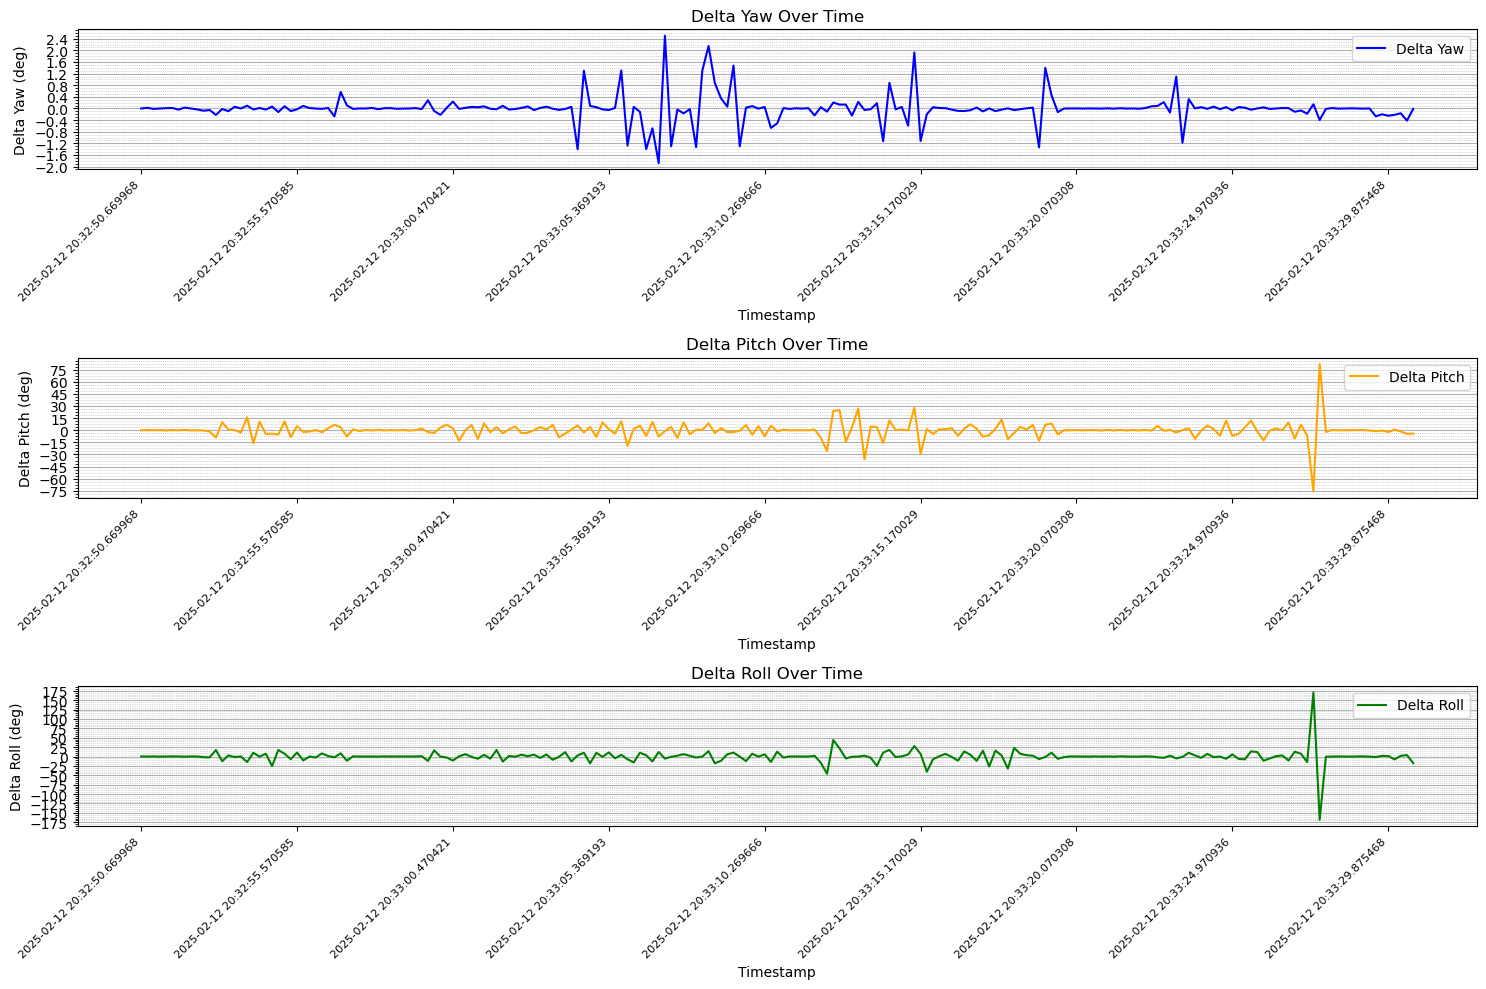

In [501]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(15, 10))

# --- Subplot 1: Delta Yaw ---
ax1 = plt.subplot(3, 1, 1)
ax1.plot(trans_imu_features['timestamp'], trans_imu_features['delta_yaw'], 
         label='Delta Yaw', color='blue')
ax1.set_title('Delta Yaw Over Time')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Delta Yaw (deg)')
ax1.legend()

# Increase the number of major ticks on Y
ax1.yaxis.set_major_locator(ticker.MaxNLocator(15))
# Enable minor ticks automatically
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# Show grid lines for both major and minor ticks
ax1.grid(which='major', axis='y', linewidth=0.8)
ax1.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

# Limit the number of X ticks to reduce clutter
ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# --- Subplot 2: Delta Pitch ---
ax2 = plt.subplot(3, 1, 2)
ax2.plot(trans_imu_features['timestamp'], trans_imu_features['delta_pitch'], 
         label='Delta Pitch', color='orange')
ax2.set_title('Delta Pitch Over Time')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Delta Pitch (deg)')
ax2.legend()

ax2.yaxis.set_major_locator(ticker.MaxNLocator(15))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.grid(which='major', axis='y', linewidth=0.8)
ax2.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# --- Subplot 3: Delta Roll ---
ax3 = plt.subplot(3, 1, 3)
ax3.plot(trans_imu_features['timestamp'], trans_imu_features['delta_roll'], 
         label='Delta Roll', color='green')
ax3.set_title('Delta Roll Over Time')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Delta Roll (deg)')
ax3.legend()

ax3.yaxis.set_major_locator(ticker.MaxNLocator(15))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.grid(which='major', axis='y', linewidth=0.8)
ax3.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

ax3.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

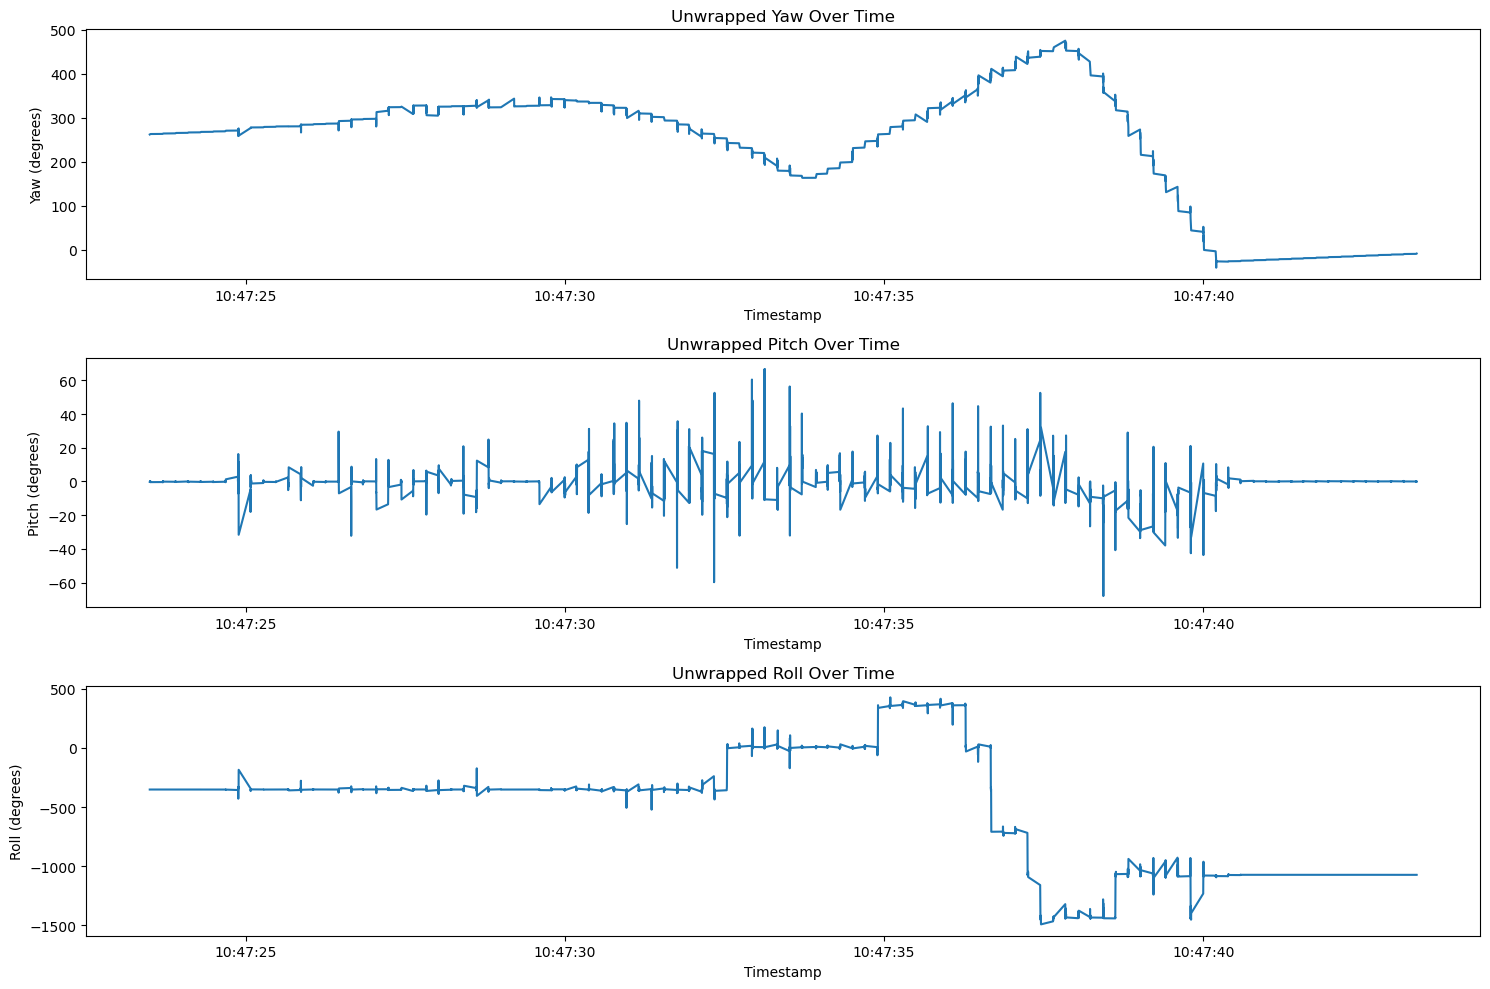

In [492]:
# Unwrap yaw, pitch, and roll to correct for discontinuities due to angular wrapping
unnested_stg_imu_data['yaw_unwrapped'] = np.unwrap(np.deg2rad(unnested_stg_imu_data['yaw'])) * (180 / np.pi)
unnested_stg_imu_data['pitch_unwrapped'] = np.unwrap(np.deg2rad(unnested_stg_imu_data['pitch'])) * (180 / np.pi)
unnested_stg_imu_data['roll_unwrapped'] = np.unwrap(np.deg2rad(unnested_stg_imu_data['roll'])) * (180 / np.pi)

# Plotting the unwrapped values
plt.figure(figsize=(15, 10))

# Unwrapped Yaw plot
plt.subplot(3, 1, 1)
plt.plot(unnested_stg_imu_data['timestamp'], unnested_stg_imu_data['yaw_unwrapped'])
plt.title('Unwrapped Yaw Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Yaw (degrees)')

# Unwrapped Pitch plot
plt.subplot(3, 1, 2)
plt.plot(unnested_stg_imu_data['timestamp'], unnested_stg_imu_data['pitch_unwrapped'])
plt.title('Unwrapped Pitch Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Pitch (degrees)')

# Unwrapped Roll plot
plt.subplot(3, 1, 3)
plt.plot(unnested_stg_imu_data['timestamp'], unnested_stg_imu_data['roll_unwrapped'])
plt.title('Unwrapped Roll Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Roll (degrees)')

plt.tight_layout()
plt.show()